In [2]:
from pathlib import Path


cwd = Path.cwd()

DATA_PATH = cwd.parent / 'datasets' / 'Image Sets' / 'Entrega 1' / 'XY51_p10'

# DATA = DATA_PATH / 'o9073g0267o.1655422.ch.2328134.XY51.p10.fits'

In [3]:
# DATA_PATH = cwd.parent / 'datasets' /'Image Sets' /' Entrega 1'
# p = DATA_PATH.parent.glob('**/*')
# files = [x for x in p if x.is_file()]
# files

# str(DATA).replace('\\','/')

---
# Leer Datos de Fits

Se leen los datos .fits con la librería astropy


In [11]:
from astropy.io import fits 
import matplotlib.pyplot as plt
import cv2

datasets=[
    DATA_PATH / 'o9073g0267o.1655422.ch.2328134.XY51.p10.fits',
    DATA_PATH / 'o9073g0283o.1655438.ch.2328150.XY51.p10.fits',
    DATA_PATH / 'o9073g0299o.1655454.ch.2328166.XY51.p10.fits',
    DATA_PATH / 'o9073g0315o.1655470.ch.2328182.XY51.p10.fits',
]

---
## Preprocess

In [12]:
def apply_f_on_rgb(img, f, args):
    
    #Crear una matriz de ceros del tamaño de la imagen de entrada
    res = np.zeros(img.shape, np.uint8)
    #Aplicar la transformación f sobre cada canal del espacio de color RGB
    res[:,:] = f(img[:,:], *args)    
    return res

def histogram_expansion(img):
    
    #Crear matriz de ceros del tamaño de la imagen y tipo de dato flotante
    res = np.zeros([img.shape[0], img.shape[1]], dtype=np.float32)
    
    #Extraer el mínimo y el máximo del conjunto de datos
    m = float(np.min(img))
    M = float(np.max(img))
    #Aplicar la función de expansión(normalización) y asegurar datos uint8
    res = (img-m)*255.0/(M-m)
    res = res.astype(np.uint8)
    
    return res

---

In [13]:

#Definir la función de transformación de la imagen (corrección gamma)
def gamma_correction(img, a, gamma):
    
    #Crear copia de la imagen tipo flotante dada la normalización
    img_copy = img.copy().astype(np.float32)/255.0
    #La función corrección gamma es de la forma ax^gamma, donde x es la imagen de entrada
    res_gamma = cv2.pow(img_copy,gamma)
    res = cv2.multiply(res_gamma, a)
    
    #Asegurar que la los datos queden entre 0 y 255 y sean uint8
    res[res<0] = 0
    res = res*255.0
    res[res>255] = 255
    
    res = res.astype(np.uint8)
    
    return res



In [14]:
def preprocess(img_original):
    img = np.clip(img_original,0,400)

    res = apply_f_on_rgb(img, histogram_expansion, [])
    res_2= cv2.equalizeHist(res)
    a = 1
    gamma = 1
    res_3 = apply_f_on_rgb(res_2, gamma_correction, [a, gamma])
    edges = cv2.Canny(res_3,100,200)
    edges[edges<128] = 0
    edges=cv2.multiply(edges,100)
    img_new=cv2.add(res_3,edges)
    return img_new

---

In [111]:
plt.style.use('dark_background')
processed_imgs=[]

for i in range(4):
    datos=fits.open(datasets[i])

    img_original = datos[0].data
    img_new=preprocess(img_original)
    processed_imgs.append(255-img_new)


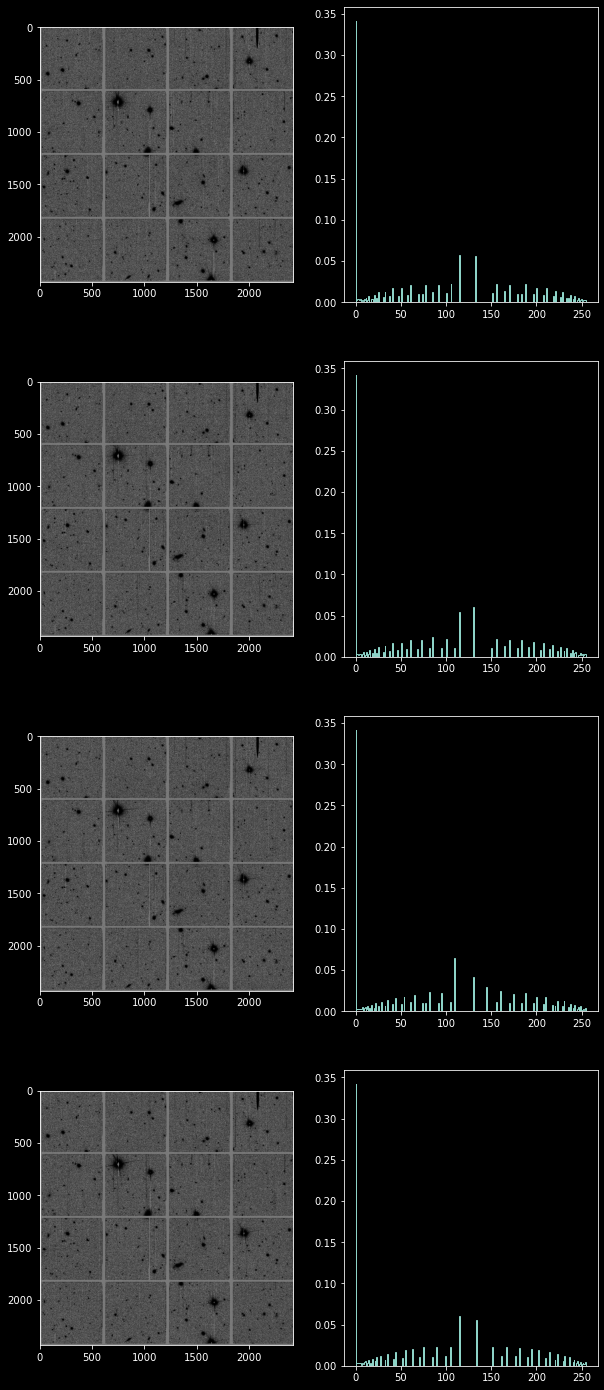

In [112]:
# fig = plt.figure(figsize=(8,8))
# plt.imshow(processed_imgs[2]-processed_imgs[1],cmap='gray_r')
fig, arreglo_plots = plt.subplots(4,2, figsize=(10, 25))
for i in range(4):
    arreglo_plots[i,0].imshow(processed_imgs[i], cmap="gray")

    img_array_i = processed_imgs[i].ravel()
    arreglo_plots[i,1].hist(img_array_i,histtype='step', bins=255, 
                                range=(0.0, 255.0),density=True)

#####################################
# arreglo_plots[1,0].imshow(processed_imgs[1], cmap="gray_r")



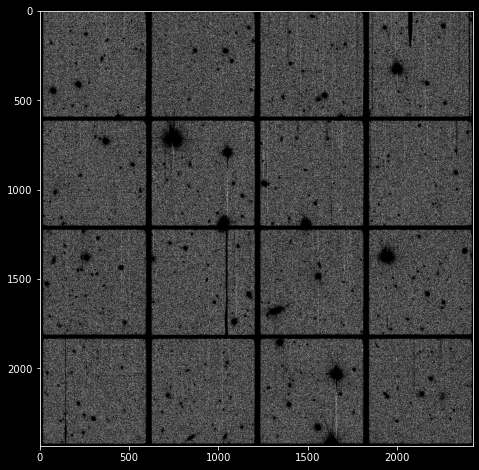

In [116]:
ret,thresh1 = cv2.threshold(processed_imgs[0],150,250,cv2.THRESH_BINARY)
fig = plt.figure(figsize=(8,8))
plt.imshow(thresh1,cmap='gray')

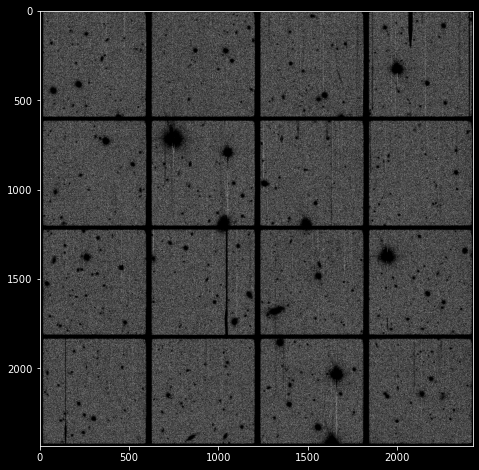

In [133]:
ret,thresh2 = cv2.threshold(processed_imgs[1],150,250,cv2.THRESH_BINARY)
thresh1=255-thresh1
thresh2=255-thresh2

img=thresh1.astype(np.float32)-thresh2.astype(np.float32)
# img=img.astype(np.uint8)

fig = plt.figure(figsize=(8,8))
plt.imshow(img,cmap='gray')

---

In [72]:
def print_img_hist(pos,image,only_one=False):
    if only_one:
        arreglo_plots[0].imshow(image, cmap="gray")

        img_array_i = image.ravel()
        arreglo_plots[1].hist(img_array_i,histtype='step', bins=255, 
                                    range=(0.0, 255.0),density=True)
    else:
        arreglo_plots[pos,0].imshow(image, cmap="gray")
        
        img_array_i = image.ravel()
        arreglo_plots[pos,1].hist(img_array_i,histtype='step', bins=255, 
                                    range=(0.0, 255.0),density=True)

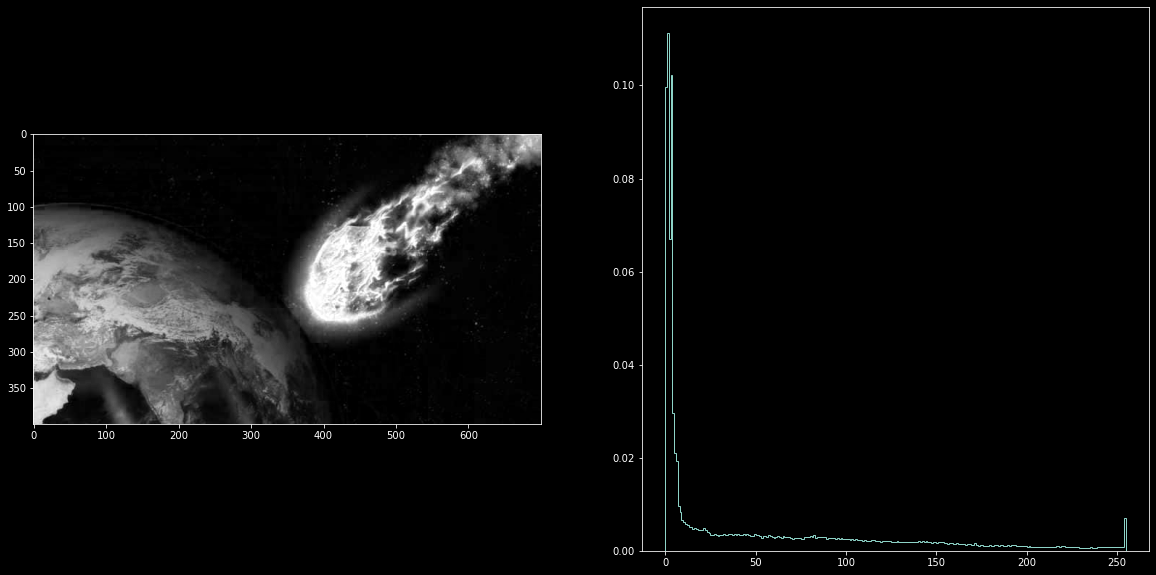

In [90]:

from skimage import io

image = io.imread('https://english.cdn.zeenews.com/sites/default/files/styles/zm_700x400/public/2021/07/24/953771-asteroid.jpg')
image=image[:,:,0]
fig, arreglo_plots = plt.subplots(1,2, figsize=(20, 10))
print_img_hist(0,image,only_one=True)


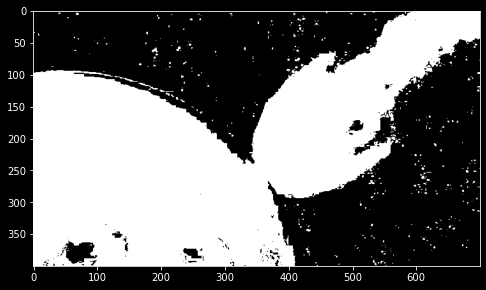

In [106]:
ret,thresh1 = cv2.threshold(image,10,256,cv2.THRESH_BINARY)
fig = plt.figure(figsize=(8,8))
plt.imshow(thresh1,cmap='gray')
